# Proyecto Redes Neuronales: Perceptrón Multicapa

**Curso:** Redes Neuronales 2025-II  
**Objetivo:** Entrenar y evaluar un modelo de Perceptrón Multicapa (MLP) para clasificación de texto según el enunciado del proyecto.  
**Autor:** Herney Eduardo Quintero Trochez  
**Fecha:** 2025  
**Universidad:** Universidad Del Valle  

## Componentes implementados:
1. Configuración de Parámetros Globales
2. Carga y Preprocesamiento de Datos
3. Tokenización y Creación del Vocabulario
4. Construcción del Modelo MLP
5. Entrenamiento con Early Stopping
6. Evaluación del Modelo
7. Guardado de Resultados y Modelos
8. Visualización de Resultados
9. Historial de Experimentos

## 0. Configuración de Parámetros Globales

Esta sección permite modificar fácilmente todos los parámetros del modelo para experimentar.

In [1]:
# ===== CONFIGURACIÓN DE PARÁMETROS GLOBALES =====
# Esta sección centraliza todos los parámetros del modelo para facilitar experimentación

# Configuración general del experimento
EXPERIMENT_NAME = "MultiLayer_Perceptron (Embedding)"  # Nombre descriptivo del experimento
MODEL_TYPE = "MLP Embedding"  # Perceptrón Multi-Capa  
RANDOM_SEED = 42

# Directorios de trabajo
DATA_DIR = "data"
MODEL_DIR = "models"
OUTPUT_DIR = "output"

# Configuración del dataset - MEJORADO CON TÍTULO
TEXT_COLUMN = "review_body"  # Columna con el texto del cuerpo de la reseña
TITLE_COLUMN = "review_title"  # Columna con el título de la reseña
TARGET_COLUMN = "stars"  # Columna con las etiquetas (1-5 estrellas)
LANGUAGE_COLUMN = "language"  # Columna con el idioma
FILTER_LANGUAGE = "en"  # Filtrar por idioma específico. Opciones: None, "en", "es", "de", "fr", "ja"
USE_TITLE_AND_BODY = True  # NUEVO: Usar tanto título como cuerpo para mejor precisión
MAX_WORDS = 80000  # Tamaño máximo del vocabulario
MAX_LENGTH = 300  # Longitud máxima de las secuencias (aumentada por combinar título+cuerpo)
OOV_TOKEN = "<OOV>"  # Token para palabras fuera del vocabulario

# Parámetros de arquitectura del modelo - MLP
EMBEDDING_DIM = 300  # Dimensión del embedding de palabras
HIDDEN_LAYERS = [256, 128, 64]  # Lista con el número de neuronas en cada capa oculta
ACTIVATION = "relu"  # Función de activación para capas ocultas
OUTPUT_ACTIVATION = "softmax"  # Función de activación para la capa de salida
DROPOUT_RATE = 0.3  # Tasa de dropout para regularización

# Parámetros de entrenamiento
EPOCHS = 50  # Número máximo de épocas de entrenamiento
BATCH_SIZE = 512  # Tamaño del batch
LEARNING_RATE = 0.001  # Tasa de aprendizaje
PATIENCE = 10  # Paciencia para early stopping
OPTIMIZER = "adam"  # Optimizador a usar
LOSS_FUNCTION = "categorical_crossentropy"  # Función de pérdida
METRICS = ["accuracy"]  # Métricas a monitorear

print(f"=== Configuración del Experimento: {EXPERIMENT_NAME} ===")
print(f"Modelo: {MODEL_TYPE}")
print(f"Filtro de idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Usar título + cuerpo: {USE_TITLE_AND_BODY}")
print(f"Longitud máxima: {MAX_LENGTH} tokens")
print(f"Arquitectura oculta: {HIDDEN_LAYERS}")
print(f"Dimensión embedding: {EMBEDDING_DIM}")
print(f"Dropout: {DROPOUT_RATE}")
print(f"Épocas máximas: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Tasa de aprendizaje: {LEARNING_RATE}")
print("="*60)

=== Configuración del Experimento: MultiLayer_Perceptron (Embedding) ===
Modelo: MLP Embedding
Filtro de idioma: en
Usar título + cuerpo: True
Longitud máxima: 300 tokens
Arquitectura oculta: [256, 128, 64]
Dimensión embedding: 300
Dropout: 0.3
Épocas máximas: 50
Batch size: 512
Tasa de aprendizaje: 0.001


## 1. Importación de Librerías y Funciones Helper

In [2]:
# ===== IMPORTAR LIBRERÍAS =====
import os
import numpy as np
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from helper import DataLoader
from helper import ModelTrainer
from helper import ResultsManager
from helper import Visualizer
from helper import evaluate_model
from helper import setup_experiment_environment
from helper import save_model_components

# Configurar ambiente del experimento
gpu_info = setup_experiment_environment(RANDOM_SEED)
print(f"Ambiente configurado. GPU disponible: {gpu_info['gpu_available']}")

2025-09-29 01:46:36.143281: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 01:46:36.180951: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-29 01:46:37.076017: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-29 01:46:37.076017: I tensorflow/core/util/port.cc:153] oneDNN custom operations ar

GPU configurada: 1 GPU(s) disponibles
Ambiente configurado. GPU disponible: True


## 2. Carga y Preprocesamiento de Datos

In [3]:
# Inicializar el cargador de datos
data_loader = DataLoader(data_dir=DATA_DIR)

# Cargar los datasets
print("Cargando datasets...")
train_df, val_df, test_df = data_loader.load_all_data()

print(f"\nDatos originales cargados:")
print(f"Entrenamiento: {len(train_df)} muestras")
print(f"Validación: {len(val_df)} muestras") 
print(f"Prueba: {len(test_df)} muestras")

# Verificar que las columnas necesarias existen
required_columns = [TEXT_COLUMN, TARGET_COLUMN, LANGUAGE_COLUMN]
if USE_TITLE_AND_BODY:
    required_columns.append(TITLE_COLUMN)

missing_columns = [col for col in required_columns if col not in train_df.columns]
if missing_columns:
    print(f"Columnas faltantes: {missing_columns}")
    print(f"Columnas disponibles: {list(train_df.columns)}")
else:
    print(f"Todas las columnas requeridas están disponibles")
    if USE_TITLE_AND_BODY:
        print(f"Modo combinado: {TITLE_COLUMN} + {TEXT_COLUMN}")

# Analizar distribución de idiomas
print(f"\nAnálisis de idiomas en el dataset:")
if LANGUAGE_COLUMN in train_df.columns:
    lang_dist_train = train_df[LANGUAGE_COLUMN].value_counts()
    print(f"Distribución de idiomas (entrenamiento):")
    for lang, count in lang_dist_train.items():
        percentage = (count / len(train_df)) * 100
        print(f"  {lang}: {count:,} muestras ({percentage:.1f}%)")
    
    # Aplicar filtro por idioma si está especificado
    if FILTER_LANGUAGE is not None:
        if FILTER_LANGUAGE in lang_dist_train.index:
            print(f"\nFiltrando por idioma: {FILTER_LANGUAGE}")
            
            # Filtrar datasets por idioma
            train_df = train_df[train_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            val_df = val_df[val_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            test_df = test_df[test_df[LANGUAGE_COLUMN] == FILTER_LANGUAGE].copy()
            
            print(f"\nDatos después del filtrado por idioma '{FILTER_LANGUAGE}':")
            print(f"Entrenamiento: {len(train_df)} muestras")
            print(f"Validación: {len(val_df)} muestras")
            print(f"Prueba: {len(test_df)} muestras")
        else:
            print(f"\nAdvertencia: Idioma '{FILTER_LANGUAGE}' no encontrado en el dataset.")
            print(f"Idiomas disponibles: {list(lang_dist_train.index)}")
            print("Usando todos los idiomas...")
    else:
        print(f"\nUsando todos los idiomas disponibles")
else:
    print(f"Columna '{LANGUAGE_COLUMN}' no encontrada. Usando todos los datos sin filtrar.")

# Mostrar distribución de clases en el conjunto final
print(f"\nDistribución de clases (conjunto final):")
class_distribution = train_df[TARGET_COLUMN].value_counts().sort_index()
for stars, count in class_distribution.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {stars} estrella(s): {count:,} muestras ({percentage:.1f}%)")

# Mostrar ejemplos de datos con título y cuerpo
print(f"\nEjemplos de datos del conjunto final:")
for i in range(min(3, len(train_df))):
    lang = train_df[LANGUAGE_COLUMN].iloc[i] if LANGUAGE_COLUMN in train_df.columns else "N/A"
    title = train_df[TITLE_COLUMN].iloc[i] if USE_TITLE_AND_BODY and TITLE_COLUMN in train_df.columns else "N/A"
    text = train_df[TEXT_COLUMN].iloc[i][:80]  # Menos texto para mostrar título también
    stars = train_df[TARGET_COLUMN].iloc[i]
    
    print(f"{i+1}. [{lang}] {stars} estrella(s)")
    if USE_TITLE_AND_BODY and title != "N/A":
        print(f"   Título: {title[:60]}{'...' if len(str(title)) > 60 else ''}")
    print(f"   Cuerpo: {text}{'...' if len(str(train_df[TEXT_COLUMN].iloc[i])) > 80 else ''}")
    print()

Cargando datasets...
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Datos originales cargados:
Entrenamiento: 1200000 muestras
Validación: 30000 muestras
Prueba: 30000 muestras
Todas las columnas requeridas están disponibles
Modo combinado: review_title + review_body

Análisis de idiomas en el dataset:
Datos cargados exitosamente: train.csv
Datos cargados exitosamente: validation.csv
Datos cargados exitosamente: test.csv

Datos originales cargados:
Entrenamiento: 1200000 muestras
Validación: 30000 muestras
Prueba: 30000 muestras
Todas las columnas requeridas están disponibles
Modo combinado: review_title + review_body

Análisis de idiomas en el dataset:
Distribución de idiomas (entrenamiento):
  de: 200,000 muestras (16.7%)
  en: 200,000 muestras (16.7%)
  es: 200,000 muestras (16.7%)
  fr: 200,000 muestras (16.7%)
  ja: 200,000 muestras (16.7%)
  zh: 200,000 muestras (16.7%)

Filtrando por idioma: en

Datos des

## 3. Preprocesamiento de Texto

In [4]:
# Preprocesar los datos de texto
print("Preprocesando datos de texto...")
print(f"Modo: {'Título + Cuerpo' if USE_TITLE_AND_BODY else 'Solo Cuerpo'}")

processed_data = data_loader.preprocess_text_data_embedding(
    train_df=train_df,
    val_df=val_df, 
    test_df=test_df,
    text_column=TEXT_COLUMN,
    title_column=TITLE_COLUMN if USE_TITLE_AND_BODY else None,
    target_column=TARGET_COLUMN,
    max_words=MAX_WORDS,
    max_length=MAX_LENGTH,
    use_title_and_body=USE_TITLE_AND_BODY
)

# Extraer datos preprocesados
X_train, y_train = processed_data['X_train'], processed_data['y_train']
X_val, y_val = processed_data['X_val'], processed_data['y_val']
X_test, y_test = processed_data['X_test'], processed_data['y_test']
num_classes = processed_data['num_classes']
vocab_size = processed_data['vocab_size']

print(f"\nDatos preprocesados:")
print(f"Tamaño del vocabulario: {vocab_size}")
print(f"Número de clases: {num_classes}")
print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Texto combinado: {'Sí (título + cuerpo)' if USE_TITLE_AND_BODY else 'No (solo cuerpo)'}")

# Obtener nombres de clases para evaluación
class_names = [str(i) for i in data_loader.label_encoder.classes_]

Preprocesando datos de texto...
Modo: Título + Cuerpo
Preprocesando datos de texto...
Tamaño del vocabulario: 49069
Número de clases: 5
Longitud de secuencia: 300
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Datos preprocesados:
Tamaño del vocabulario: 49070
Número de clases: 5
Forma de X_train: (200000, 300)
Forma de y_train: (200000, 5)
Texto combinado: Sí (título + cuerpo)
Tamaño del vocabulario: 49069
Número de clases: 5
Longitud de secuencia: 300
Texto combinado: Sí (título + cuerpo)
Muestras de entrenamiento: 200000
Muestras de validación: 5000
Muestras de prueba: 5000

Datos preprocesados:
Tamaño del vocabulario: 49070
Número de clases: 5
Forma de X_train: (200000, 300)
Forma de y_train: (200000, 5)
Texto combinado: Sí (título + cuerpo)


## 4. Construcción del Modelo MLP

In [5]:
def create_mlp_model(vocab_size, embedding_dim, max_length, hidden_layers, 
                     num_classes, dropout_rate, activation, output_activation):
    """
    Crear un modelo de Perceptrón Multicapa para clasificación de texto.
    
    Args:
        vocab_size: Tamaño del vocabulario
        embedding_dim: Dimensión del embedding
        max_length: Longitud máxima de secuencia
        hidden_layers: Lista con el número de neuronas en cada capa oculta
        num_classes: Número de clases de salida
        dropout_rate: Tasa de dropout
        activation: Función de activación para capas ocultas
        output_activation: Función de activación para la capa de salida
    
    Returns:
        tf.keras.Model: Modelo compilado
    """
    model = Sequential()
    
    # Capa de embedding (sin input_length que está deprecado)
    model.add(Embedding(input_dim=vocab_size, 
                       output_dim=embedding_dim,
                       name="embedding_layer"))
    
    # Pooling global para reducir dimensionalidad
    model.add(GlobalAveragePooling1D(name="global_avg_pooling"))
    
    # Capas ocultas del MLP
    for i, units in enumerate(hidden_layers):
        model.add(Dense(units=units, 
                       activation=activation, 
                       name=f"dense_layer_{i+1}"))
        model.add(Dropout(rate=dropout_rate, 
                         name=f"dropout_{i+1}"))
    
    # Capa de salida
    model.add(Dense(units=num_classes, 
                   activation=output_activation, 
                   name="output_layer"))
    
    return model

# Crear el modelo
print("Creando modelo MLP...")
model = create_mlp_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_LENGTH,
    hidden_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    activation=ACTIVATION,
    output_activation=OUTPUT_ACTIVATION
)

# Compilar el modelo
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss=LOSS_FUNCTION,
    metrics=METRICS
)

# Construir el modelo con la forma de entrada específica
model.build(input_shape=(None, MAX_LENGTH))

# Mostrar arquitectura del modelo
print("\nArquitectura del modelo:")
model.summary()

# Contar parámetros
total_params = model.count_params()
print(f"\nTotal de parámetros: {total_params:,}")

Creando modelo MLP...


I0000 00:00:1759128409.242733  178858 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9489 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6



Arquitectura del modelo:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 300, 300)       │    14,721,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_avg_pooling              │ (None, 300)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 256)            │        77,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_2 (Dense)           │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_3 (Dense)           │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,533 (56.61 MB)

 Trainable params: 14,839,533 (56.61 MB)

 Non-trainable params: 0 (0.00 B)


Total de parámetros: 14,839,533


## 5. Entrenamiento del Modelo

In [6]:
# Inicializar el entrenador de modelos
model_trainer = ModelTrainer(model_dir=MODEL_DIR)

# Entrenar el modelo
print("Iniciando entrenamiento...")
training_results = model_trainer.train_model(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    patience=PATIENCE,
    model_name=f"{MODEL_TYPE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
)

print(f"\nEntrenamiento completado:")
print(f"Épocas entrenadas: {training_results['epochs_trained']}")
print(f"Tiempo de entrenamiento: {training_results['training_time']:.1f} segundos")
print(f"Accuracy final (entrenamiento): {training_results['final_train_accuracy']:.4f}")
print(f"Accuracy final (validación): {training_results['final_val_accuracy']:.4f}")

# ========== NUEVO: GUARDAR COMPONENTES DEL MODELO ==========
print("\nGuardando componentes del modelo...")

# Extraer nombre del modelo desde la ruta guardada
model_name = os.path.basename(training_results['model_path']).replace('.h5', '')

# Guardar modelo y todos sus componentes (Embedding)
save_model_components(
    model_name=model_name,
    model=model,
    vectorizer=None,  # No se usa vectorizer en embedding
    tokenizer=data_loader.tokenizer,  # Para modelo de embedding
    label_encoder=data_loader.label_encoder,
    model_dir=MODEL_DIR
)

print(f"Componentes del modelo guardados exitosamente como '{model_name}'")

Iniciando entrenamiento...
Entrenando MLP Embedding_20250929_014649...
Parámetros del modelo: 14,839,533
Forma de entrada: (200000, 300)
Tipo de datos: float32
Epoch 1/50
Epoch 1/50


2025-09-29 01:46:50.722608: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ff214003cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-29 01:46:50.722639: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-09-29 01:46:50.747046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-29 01:46:50.890095: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91300
2025-09-29 01:46:51.009008: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 01:46:51.009058: I e

  7/391 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.2029 - loss: 1.6105

I0000 00:00:1759128414.569409  182394 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


388/391 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2096 - loss: 1.6064

2025-09-29 01:47:02.996023: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 01:47:02.996075: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 01:47:03.843611: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1599', 4 bytes spill stores, 4 bytes spill loads

2025-09-29 01:47:03.843611: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : R

391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2097 - loss: 1.6063

2025-09-29 01:47:06.149678: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 01:47:06.661983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 116 bytes spill stores, 116 bytes spill loads

2025-09-29 01:47:06.661983: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_105', 116 bytes spill stores, 116 bytes spill loads

2025-09-29 01:47:07.324294: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints 

391/391 ━━━━━━━━━━━━━━━━━━━━ 19s 36ms/step - accuracy: 0.2265 - loss: 1.6003 - val_accuracy: 0.2012 - val_loss: 1.6089 - learning_rate: 0.0010
Epoch 2/50
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2364 - loss: 1.5944 - val_accuracy: 0.2412 - val_loss: 1.5892 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2364 - loss: 1.5944 - val_accuracy: 0.2412 - val_loss: 1.5892 - learning_rate: 0.0010
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2476 - loss: 1.5826 - val_accuracy: 0.3372 - val_loss: 1.4382 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2476 - loss: 1.5826 - val_accuracy: 0.3372 - val_loss: 1.4382 - learning_rate: 0.0010
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3158 - loss: 1.4686 - val_accuracy: 0.3908 - val_loss: 1.3180 - learning_rate: 0.0010
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3158 - loss: 1

Modelo guardado en: models/MLP Embedding_20250929_014649.h5

Entrenamiento completado:
Épocas entrenadas: 34
Tiempo de entrenamiento: 289.3 segundos
Accuracy final (entrenamiento): 0.6523
Accuracy final (validación): 0.5924

Guardando componentes del modelo...
Modelo guardado: models/MLP Embedding_20250929_014649.h5
Tokenizer guardado: models/MLP Embedding_20250929_014649_tokenizer.pkl
Label encoder guardado: models/MLP Embedding_20250929_014649_label_encoder.pkl
Todos los componentes del modelo 'MLP Embedding_20250929_014649' guardados correctamente en models/
Componentes del modelo guardados exitosamente como 'MLP Embedding_20250929_014649'
Modelo guardado: models/MLP Embedding_20250929_014649.h5
Tokenizer guardado: models/MLP Embedding_20250929_014649_tokenizer.pkl
Label encoder guardado: models/MLP Embedding_20250929_014649_label_encoder.pkl
Todos los componentes del modelo 'MLP Embedding_20250929_014649' guardados correctamente en models/
Componentes del modelo guardados exitosame

## 6. Visualización del Entrenamiento

Gráfico de historial de entrenamiento guardado en: output/MLP Embedding_training_history.png


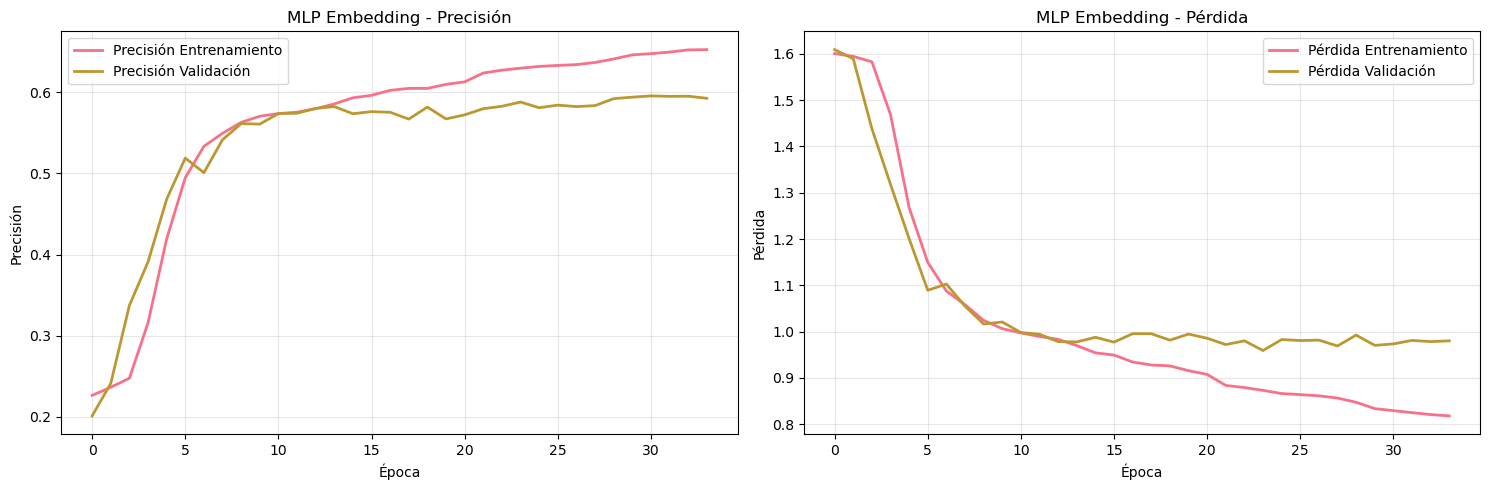

In [7]:
# Visualizar el historial de entrenamiento
Visualizer.plot_training_history(
    history=training_results['history'],
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_training_history.png")
)

## 7. Evaluación del Modelo

In [8]:
# Evaluar el modelo en el conjunto de prueba
evaluation_results = evaluate_model(
    model=model,
    X_test=X_test,
    y_test=y_test,
    class_names=class_names
)

# Extraer métricas de evaluación
test_accuracy = evaluation_results['test_accuracy']
test_loss = evaluation_results['test_loss']
classification_rep = evaluation_results['classification_report']
y_true = evaluation_results['y_true']
y_pred = evaluation_results['y_pred']

print(f"\nResultados en conjunto de prueba:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Loss: {test_loss:.4f}")
print(f"F1-Score (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"F1-Score (weighted): {classification_rep['weighted avg']['f1-score']:.4f}")

Evaluando modelo en datos de prueba...


2025-09-29 01:51:40.050596: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 01:51:40.050619: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-29 01:51:40.254829: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 8 bytes spill stores, 8 bytes spill loads

2025-09-29 01:51:40.254829: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

122/157 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step

2025-09-29 01:51:42.070304: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 8 bytes spill stores, 8 bytes spill loads



157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Precisión de Prueba: 0.5908
Pérdida de Prueba: 0.9606

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.72      0.66      0.69      1000
           2       0.49      0.52      0.50      1000
           3       0.47      0.49      0.48      1000
           4       0.59      0.47      0.52      1000
           5       0.69      0.82      0.75      1000

    accuracy                           0.59      5000
   macro avg       0.59      0.59      0.59      5000
weighted avg       0.59      0.59      0.59      5000


Resultados en conjunto de prueba:
Accuracy: 0.5908
Loss: 0.9606
F1-Score (macro): 0.5884
F1-Score (weighted): 0.5884
Precisión de Prueba: 0.5908
Pérdida de Prueba: 0.9606

Reporte de Clasificación:
              precision    recall  f1-score   support

           1       0.72      0.66      0.69      1000
           2       0.49      0.52      0

## 8. Matriz de Confusión

Matriz de confusión guardada en: output/MLP Embedding_confusion_matrix.png


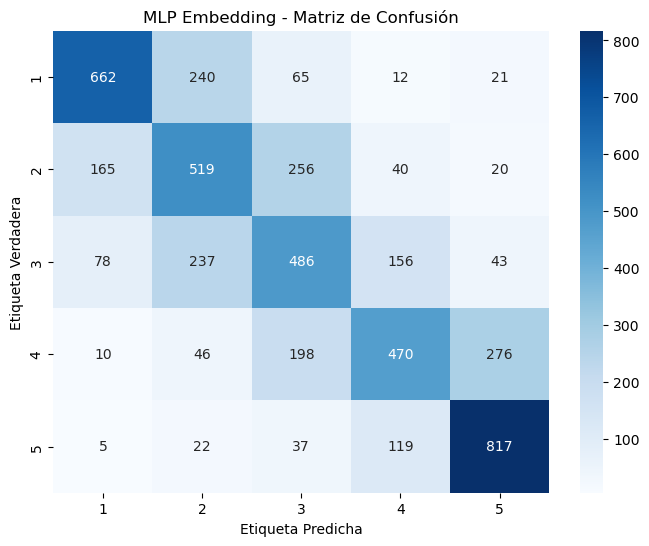

In [9]:
# Visualizar matriz de confusión
Visualizer.plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    class_names=class_names,
    model_name=MODEL_TYPE,
    save_path=os.path.join(OUTPUT_DIR, f"{MODEL_TYPE}_confusion_matrix.png")
)

## 9. Guardado de Resultados del Experimento

In [10]:
# Preparar datos del experimento para guardar
experiment_data = {
    'experiment_name': EXPERIMENT_NAME,
    'configuration': {
        'model_type': MODEL_TYPE,
        'text_column': TEXT_COLUMN,
        'target_column': TARGET_COLUMN,
        'language_filter': FILTER_LANGUAGE,  # ← Nueva información de idioma
        'max_words': MAX_WORDS,
        'max_length': MAX_LENGTH,
        'embedding_dim': EMBEDDING_DIM,
        'hidden_layers': HIDDEN_LAYERS,
        'activation': ACTIVATION,
        'output_activation': OUTPUT_ACTIVATION,
        'dropout_rate': DROPOUT_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'patience': PATIENCE,
        'optimizer': OPTIMIZER,
        'loss_function': LOSS_FUNCTION,
        'random_seed': RANDOM_SEED,
        'total_parameters': total_params,
        'gpu_used': gpu_info['gpu_available']
    },
    'dataset_info': {
        'train_samples': len(train_df),
        'val_samples': len(val_df),
        'test_samples': len(test_df),
        'num_classes': num_classes,
        'vocab_size': vocab_size,
        'class_distribution': class_distribution.to_dict(),
        'language_used': FILTER_LANGUAGE if FILTER_LANGUAGE else "multilingual"  # ← Nueva información
    },
    'training_results': training_results,
    'evaluation_metrics': {
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'f1_macro': classification_rep['macro avg']['f1-score'],
        'f1_weighted': classification_rep['weighted avg']['f1-score'],
        'precision_macro': classification_rep['macro avg']['precision'],
        'recall_macro': classification_rep['macro avg']['recall'],
        'classification_report': classification_rep
    },
    'gpu_info': gpu_info
}

# Guardar resultados del experimento
results_manager = ResultsManager(output_dir=OUTPUT_DIR)
experiment_id = results_manager.save_experiment_results(experiment_data)

print(f"\nExperimento #{experiment_id} guardado exitosamente.")
print(f"Idioma utilizado: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma'}")
print(f"Modelo guardado en: {training_results['model_path']}")
print(f"Resultados guardados en: {OUTPUT_DIR}/experiment_history.json")

Experiment 2 results saved to output/experiment_history.json

Experimento #2 guardado exitosamente.
Idioma utilizado: en
Modelo guardado en: models/MLP Embedding_20250929_014649.h5
Resultados guardados en: output/experiment_history.json


## 10. Resumen del Experimento

In [11]:
# Mostrar resumen del experimento actual
print(f"RESUMEN DEL EXPERIMENTO #{experiment_id}")
print("=" * 60)
print(f"Modelo: {MODEL_TYPE}")
print(f"Idioma: {FILTER_LANGUAGE if FILTER_LANGUAGE else 'Multiidioma (todos)'}")
print(f"Arquitectura: {HIDDEN_LAYERS}")
print(f"Parámetros totales: {total_params:,}")
print(f"")
print(f"Dataset:")
print(f"  - Entrenamiento: {len(train_df):,} muestras")
print(f"  - Validación: {len(val_df):,} muestras")
print(f"  - Prueba: {len(test_df):,} muestras")
print(f"")
print(f"Entrenamiento:")
print(f"  - Épocas: {training_results['epochs_trained']}/{EPOCHS}")
print(f"  - Tiempo: {training_results['training_time']:.1f}s")
print(f"  - Batch size: {BATCH_SIZE}")
print(f"  - Learning rate: {LEARNING_RATE}")
print(f"")
print(f"Resultados:")
print(f"  - Test Accuracy: {test_accuracy:.4f}")
print(f"  - Test Loss: {test_loss:.4f}")
print(f"  - F1-Score (macro): {classification_rep['macro avg']['f1-score']:.4f}")
print(f"  - F1-Score (weighted): {classification_rep['weighted avg']['f1-score']:.4f}")
print(f"")
print(f"Hardware: {'GPU' if gpu_info['gpu_available'] else 'CPU'}")

# Mostrar distribución de clases final
print(f"")
print(f"Distribución de clases utilizadas:")
for stars, count in class_distribution.items():
    percentage = (count / len(train_df)) * 100
    print(f"  {stars} estrella(s): {count:,} ({percentage:.1f}%)")

RESUMEN DEL EXPERIMENTO #2
Modelo: MLP Embedding
Idioma: en
Arquitectura: [256, 128, 64]
Parámetros totales: 14,839,533

Dataset:
  - Entrenamiento: 200,000 muestras
  - Validación: 5,000 muestras
  - Prueba: 5,000 muestras

Entrenamiento:
  - Épocas: 34/50
  - Tiempo: 289.3s
  - Batch size: 512
  - Learning rate: 0.001

Resultados:
  - Test Accuracy: 0.5908
  - Test Loss: 0.9606
  - F1-Score (macro): 0.5884
  - F1-Score (weighted): 0.5884

Hardware: GPU

Distribución de clases utilizadas:
  1 estrella(s): 40,000 (20.0%)
  2 estrella(s): 40,000 (20.0%)
  3 estrella(s): 40,000 (20.0%)
  4 estrella(s): 40,000 (20.0%)
  5 estrella(s): 40,000 (20.0%)


## 11. Historial de Experimentos

In [12]:
# Mostrar historial completo de experimentos
results_manager.display_experiment_history()


HISTORIAL DE EXPERIMENTOS (2 experimentos)

ID  Modelo       Lang   Precisión  Pérdida    Épocas   Tiempo (s) Muestras  
-----------------------------------------------------------------------------------------------
1   MLP_BoW      en     0.5034     1.7104     11       33.3       200,000   
2   MLP Embeddi  en     0.5924     0.9801     34       289.3      200,000   

BEST EXPERIMENTS BY LANGUAGE:
--------------------------------------------------
en    : ID #2 - Accuracy: 0.5924 (200,000 samples)

OVERALL BEST: ID #2 (en) - Accuracy: 0.5924


## 12. Análisis de Errores

In [13]:
# Analizar algunos errores del modelo
def analyze_errors(X_test, y_test, y_pred, test_df, text_column, target_column, n_examples=5):
    """
    Analizar ejemplos donde el modelo se equivocó.
    """
    # Encontrar índices donde el modelo se equivocó
    y_test_labels = np.argmax(y_test, axis=1)
    error_indices = np.where(y_test_labels != y_pred)[0]
    
    if len(error_indices) == 0:
        print("Perfecto. El modelo no cometió errores en el conjunto de prueba.")
        return
    
    print(f"ANÁLISIS DE ERRORES ({len(error_indices)} errores total)")
    print("=" * 60)
    
    # Mostrar algunos ejemplos de errores
    sample_errors = np.random.choice(error_indices, 
                                   min(n_examples, len(error_indices)), 
                                   replace=False)
    
    for i, idx in enumerate(sample_errors):
        true_label = y_test_labels[idx]
        pred_label = y_pred[idx]
        text = test_df.iloc[idx][text_column]
        
        print(f"Error #{i+1}:")
        print(f"Texto: {text[:150]}...")
        print(f"Etiqueta real: {true_label + 1} estrellas")
        print(f"Predicción: {pred_label + 1} estrellas")
        print("-" * 40)

# Realizar análisis de errores
analyze_errors(X_test, y_test, y_pred, test_df, TEXT_COLUMN, TARGET_COLUMN)

ANÁLISIS DE ERRORES (2046 errores total)
Error #1:
Texto: At first I loved it because it looked good and was light weight. However, the magnet stuck to everything that my arm came in contact with and pulled m...
Etiqueta real: 1 estrellas
Predicción: 2 estrellas
----------------------------------------
Error #2:
Texto: I’m usually a medium. 5’5” about 145-150 pounds. This was a little small in the bust area. I’m a 36B. Would recommend getting the next size up if you ...
Etiqueta real: 3 estrellas
Predicción: 4 estrellas
----------------------------------------
Error #3:
Texto: My daughter loves JoJo but this backpack is not stitched well. First day carrying to the school bus the top loop broke out....
Etiqueta real: 2 estrellas
Predicción: 3 estrellas
----------------------------------------
Error #4:
Texto: I sent this back. It had my body fat extremely low, and while I’d love to believe that what it says is true, I know it’s not accurate. And what’s the ...
Etiqueta real: 2 estrellas

## 13. Predicciones de Ejemplo

In [14]:
def predict_sample_texts(model, tokenizer, sample_texts, class_names, max_length):
    """
    Hacer predicciones en textos de ejemplo.
    
    Args:
        model: Modelo entrenado
        tokenizer: Tokenizer usado para entrenar
        sample_texts: Lista de textos de ejemplo
        class_names: Nombres de las clases
        max_length: Longitud máxima de secuencia
    """
    # Procesar textos
    sequences = tokenizer.texts_to_sequences(sample_texts)
    padded = tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=max_length, padding='post', truncating='post'
    )
    
    # Hacer predicciones
    predictions = model.predict(padded)
    predicted_classes = np.argmax(predictions, axis=1)
    
    print("PREDICCIONES DE EJEMPLO:")
    print("=" * 60)
    
    for i, text in enumerate(sample_texts):
        pred_class = predicted_classes[i]
        confidence = predictions[i][pred_class]
        
        print(f"Texto: {text[:100]}...")
        print(f"Predicción: {class_names[pred_class]} estrellas (confianza: {confidence:.3f})")
        print("-" * 40)

# Ejemplos de textos para probar - MEJORADOS CON TÍTULOS
if USE_TITLE_AND_BODY:
    sample_texts = [
        "Excellent product This product is excellent, very good quality and arrived quickly",
        "Terrible product Terrible product, does not work as described", 
        "Normal product The product is fine, meets the basics",
        "Amazing product Incredible quality, completely exceeded my expectations",
        "Not recommended I do not recommend this product, very bad experience"
    ]
    print("Usando formato: [TÍTULO] + [CUERPO] procesado con BoW/TF-IDF")
else:
    sample_texts = [
        "This product is excellent, very good quality and arrived quickly",
        "Terrible product, does not work as described", 
        "The product is fine, meets the basics",
        "Incredible quality, completely exceeded my expectations",
        "I do not recommend this product, very bad experience"
    ]
    print("Usando formato: solo [CUERPO] procesado con BoW/TF-IDF")

# Hacer predicciones en ejemplos
predict_sample_texts(
    model=model,
    tokenizer=data_loader.tokenizer,
    sample_texts=sample_texts,
    class_names=class_names,
    max_length=MAX_LENGTH
)

Usando formato: [TÍTULO] + [CUERPO] procesado con BoW/TF-IDF


2025-09-29 01:51:44.295561: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_42', 8 bytes spill stores, 8 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
PREDICCIONES DE EJEMPLO:
Texto: Excellent product This product is excellent, very good quality and arrived quickly...
Predicción: 5 estrellas (confianza: 0.918)
----------------------------------------
Texto: Terrible product Terrible product, does not work as described...
Predicción: 1 estrellas (confianza: 0.952)
----------------------------------------
Texto: Normal product The product is fine, meets the basics...
Predicción: 4 estrellas (confianza: 0.397)
----------------------------------------
Texto: Amazing product Incredible quality, completely exceeded my expectations...
Predicción: 5 estrellas (confianza: 0.964)
----------------------------------------
Texto: Not recommended I do not recommend this product, very bad experience...
Predicción: 1 estrellas (confianza: 0.801)
----------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
PREDICCIONES DE EJEMPLO:
Texto: Excellent product This product is excellent, very good q